In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math as math
from tqdm.notebook import tqdm, trange

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Assignment-3/images/'

Mounted at /content/drive


### Utils


In [ ]:
def read_image(name):
  img = cv2.imread(path + name)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return gray

In [ ]:
l1 = read_image("l1.png")
l2 = read_image("l2.png")
l3 = read_image("l3.png")
r1 = read_image("r1.png")
r2 = read_image("r2.png")
r3 = read_image("r3.png")

In [ ]:
def print_two_images(img1, img2, title1, title2, show_axis = False):
  fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,8))
  if not show_axis:
    ax[0].axis('off')
    ax[0].title.set_text(title1)
    ax[0].imshow(img1,cmap='gray')

  if not show_axis:
    ax[1].axis('off')
    ax[1].title.set_text(title2)
    ax[1].imshow(img2,cmap='gray')

In [ ]:
def print_three_images(img1, img2,img3, title1, title2,title3, show_axis = False):
  fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(20,8))
  if not show_axis:
    ax[0].axis('off')
  ax[0].title.set_text(title1)
  ax[0].imshow(img1,cmap='gray')

  if not show_axis:
    ax[1].axis('off')
  ax[1].title.set_text(title2)
  ax[1].imshow(img2,cmap='gray')

  if not show_axis:
    ax[2].axis('off')
  ax[2].title.set_text(title3)
  ax[2].imshow(img2,cmap='gray')

### Block Matching

In [ ]:
def calc_SAD(block1,block2):
  return np.sum(abs(np.subtract(block1, block2)))

In [ ]:
def calc_SSD(block1,block2):
  return np.sum(np.square(np.subtract(block1,block2)))

In [ ]:
def plot_images(right_image,left_image,window_sizes,shift_window):
  ssd_images = []
  sad_images = []
  for w in window_sizes:
    ssd = calc_matches(right_image,left_image,w,"SSD", shift_window=35)
    sad = calc_matches(right_image,left_image,w,"SAD", shift_window=35)
    ssd_images.append(ssd)
    sad_images.append(sad)

  print_three_images(ssd_images[0], ssd_images[1], ssd_images[2], "SSD W=1","SSD W=5","SSD W=9")
  print_three_images(sad_images[0], sad_images[1], sad_images[2], "SAD W=1","SAD W=5","SAD W=9")  

In [ ]:
# Start from left image point, not from start
# Limit the window of the pixels

def calc_matches(img1,img2,w=1,method = "SAD", shift_window=35):
  height, width = img1.shape
  disparity_matrix = np.zeros((height, width))
  center = w//2 

  # Loops on Rows
  for i in trange(center , height - center):

    # Pixel Loop on left image
    for j in range(center , width - center):

      left_window = img1[i - center :i + center + 1 , j - center:j + center + 1]
      min_disparity = 10000000
      disparity = 0

      # Pixel loop on right image
      max_range =  min(j + width - center, width - center)
      max_range =  min(max_range, j + shift_window)

      for j2 in range(j , max_range , 1):

        right_window = img2[i - center:i + center + 1  , j2 - center:j2 + center + 1]
        if method == "SAD":
          sad = calc_SAD(left_window,right_window)
          if sad < min_disparity:
            min_disparity = sad
            disparity = j2

        if method == "SSD":
          ssd = calc_SSD(left_window,right_window)
          if ssd < min_disparity:
            min_disparity = ssd
            disparity = j2    
                
      disparity_matrix[i,j] = disparity - j 

  return disparity_matrix/disparity_matrix.max()    


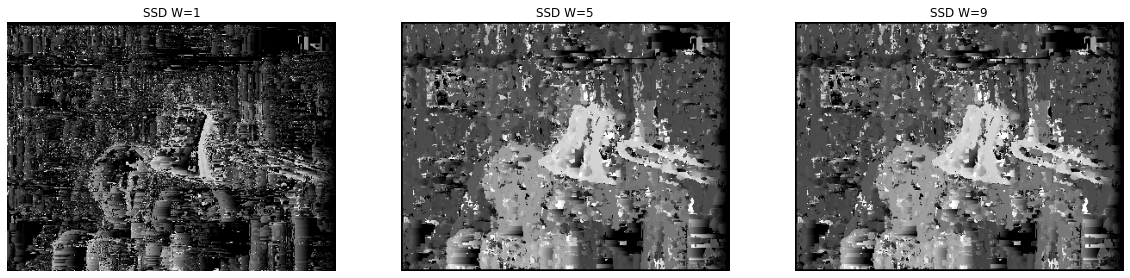

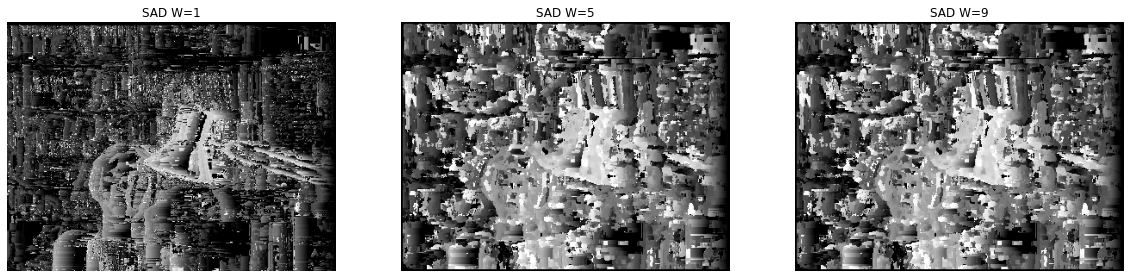

In [ ]:
plot_images(r1,l1,[1,5,9],35)

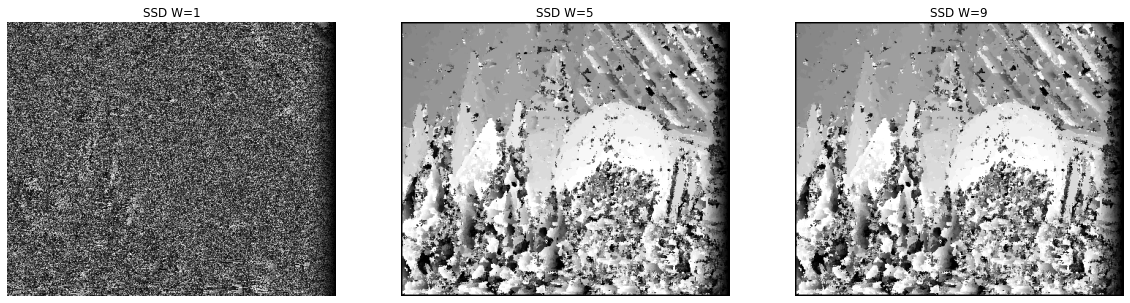

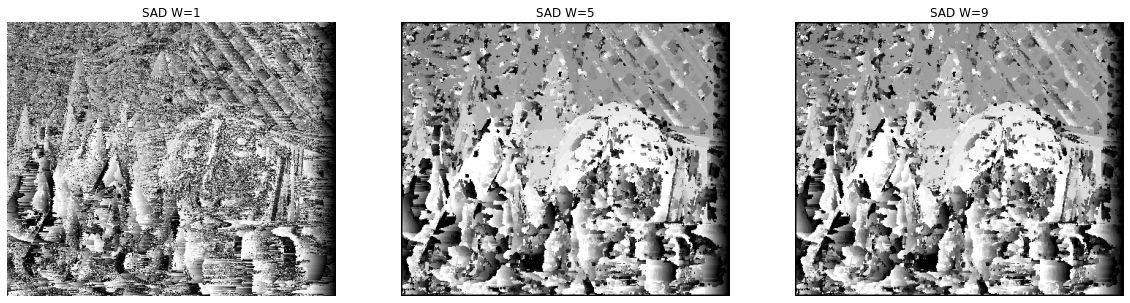

In [ ]:
plot_images(r2,l2,[1,5,9],40)

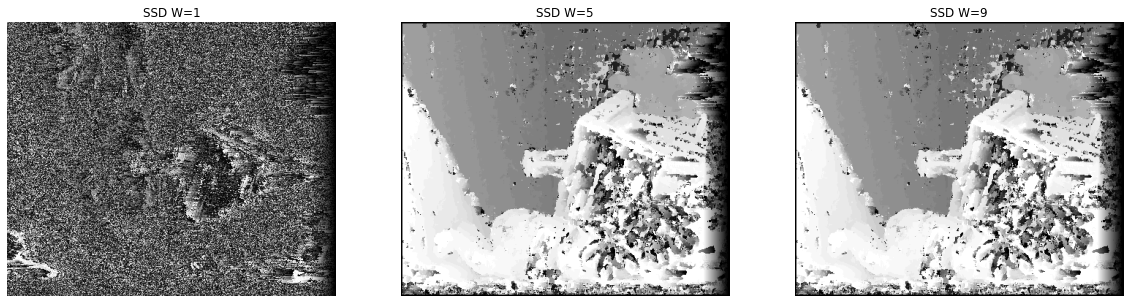

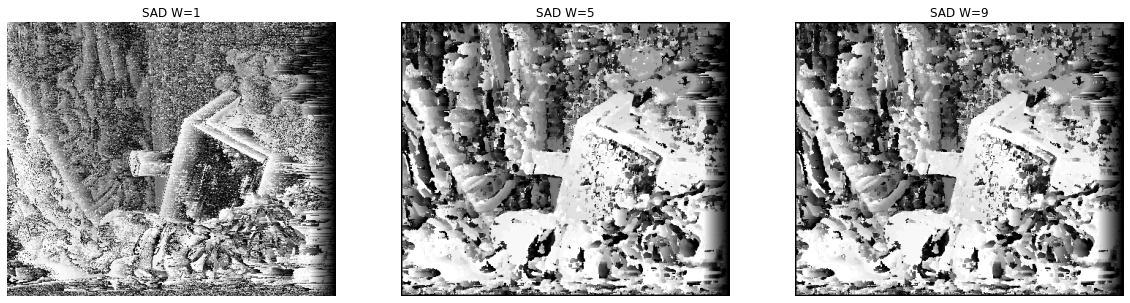

In [ ]:
plot_images(r3,l3,[1,5,9],40)

## Dynamic Prog

In [46]:
def calc_disparity_dp(img1,img2):

  def d(i, j, sigma, row):
    return pow(img1[row,i] - img2[row, j],2) /  pow(sigma, 2)

  def D(i, j, row):

    if i == 0 and j == 0:
      match_mat[i,j] = 1
      return d(0, 0, 2, row)

    if i < 0 or j < 0:
      return float("inf")

    if memo_mat[i,j] != -1:
      return memo_mat[i,j]

    else:
      v1 = D(i-1,j-1, row) + d(i,j,2, row)
      v2 = D(i-1, j, row) + 1
      v3 = D(i, j-1, row) + 1

      minVal = min(v1, v2 ,v3)
      memo_mat[i,j] = minVal    

      if v1 == minVal:
        match_mat[i,j] = 1
      if v2 == minVal:
        match_mat[i,j] = 2
      if v3 == minVal:
        match_mat[i,j] = 3

      return minVal

  width = img1.shape[1]
  height = img1.shape[0]

  disparity_matrix = np.zeros((height, width))    

  for i in trange(height):
    match_mat = np.full((width, width), -1)
    memo_mat =  np.full((width, width), -1)
    draw_mat =  np.zeros((width, width))
    minCost = D(width - 1, width - 1, i)

    p = width-1
    q = width-1

    # Back tracking the path to calculate the disparity matrix
    while p != 0 and q != 0:
      if match_mat[p,q] == 1:   
        disparity_matrix[i,p] = abs(p-q)
        p -= 1
        q -= 1
      elif match_mat[p,q] == 2:  
        disparity_matrix[i,p] = 0
        p -= 1
      elif match_mat[p,q] == 3:  
        disparity_matrix[i,p] = 0
        q -= 1
      draw_mat[p,q] = 255
    # draw graph for the last row  
    if i == height-1:
      plt.figure(figsize=(10,10))    
      plt.imshow(draw_mat, cmap = "gray")

  plt.figure(figsize=(10,10))      
  plt.imshow(disparity_matrix, cmap = "gray")      

  0%|          | 0/289 [00:00<?, ?it/s]

<ipython-input-46-44df685299b6>:4: RuntimeWarning: overflow encountered in ubyte_scalars
  return pow(img1[row,i] - img2[row, j],2) /  pow(sigma, 2)


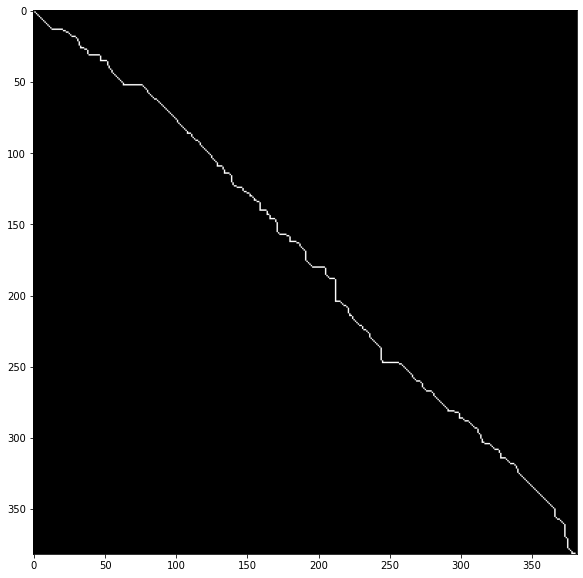

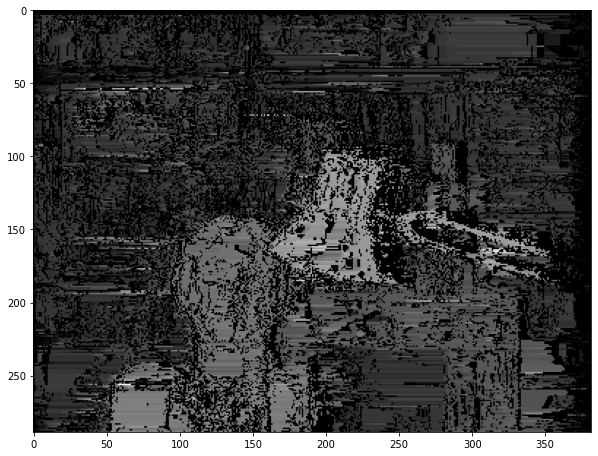

In [47]:
calc_disparity_dp(r1,l1)

  0%|          | 0/375 [00:00<?, ?it/s]

<ipython-input-46-44df685299b6>:4: RuntimeWarning: overflow encountered in ubyte_scalars
  return pow(img1[row,i] - img2[row, j],2) /  pow(sigma, 2)


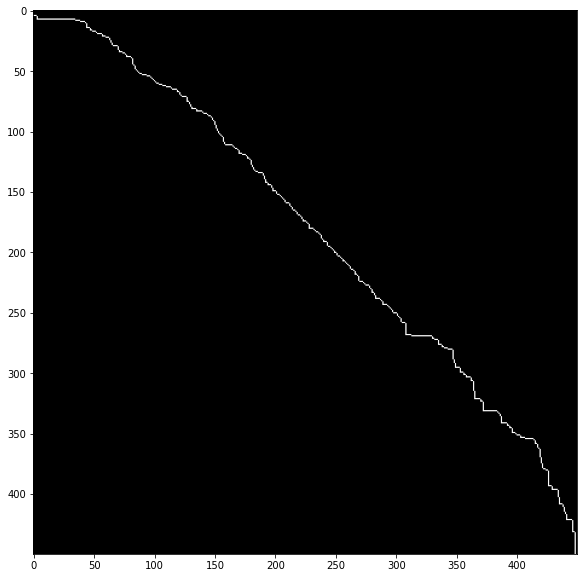

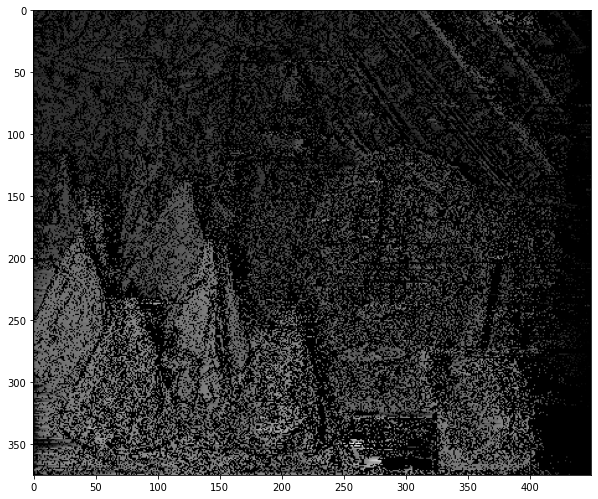

In [48]:
calc_disparity_dp(r2,l2)

  0%|          | 0/375 [00:00<?, ?it/s]

<ipython-input-46-44df685299b6>:4: RuntimeWarning: overflow encountered in ubyte_scalars
  return pow(img1[row,i] - img2[row, j],2) /  pow(sigma, 2)


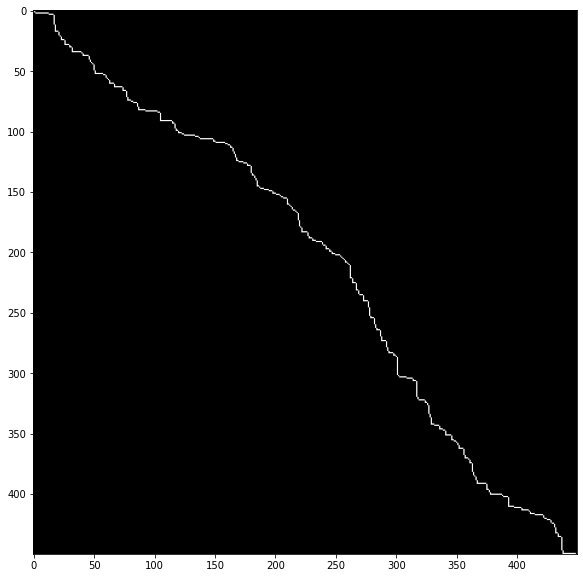

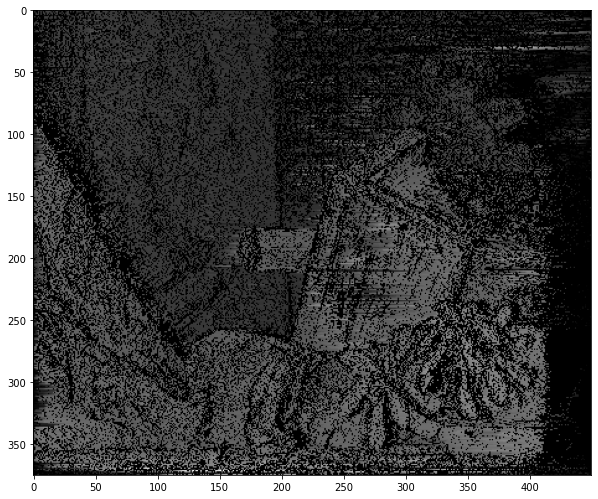

In [49]:
calc_disparity_dp(r3,l3)